In [16]:
import gspread
import datetime
import requests
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

CODE = '1LyxXkYYPWU_UkuydQhpPWlc-DAM2oMYXKrX4AryEkH8'

gc = gspread.service_account(filename = '../key.json')
sh = gc.open_by_key(CODE)

ws = sh.worksheet('Extrato Investimentos') #Lista dos WS

_values = ws.get_values(value_render_option='UNFORMATTED_VALUE')

In [17]:
df_values = pd.DataFrame(_values[1:], columns = _values[0])
df_values.drop(columns=['ID'], inplace=True)

time_init = datetime.datetime(1899, 12, 30)
timedelta = pd.to_timedelta(df_values.Data, 'd')

df_values.loc[:, 'Data'] = time_init + timedelta
df_values.drop(columns=['Preço Médio'], inplace=True)

In [46]:
df_values = df_values[df_values['Ativo'] != 'PICPAY']

In [47]:
dict_transform = {
    'ITSA3': 'ITSA3',
    'BBDC4': 'BBDC4',
    'PICPAY': 'PICPAY',
    'BITCOIN': 'BTC',
    'ETHEREUM': 'ETH',
    'USDCOIN': 'USDC',
    'PAX GOLD': 'PAXG',
    'XRP': 'XRP',
    'LITECOIN': 'LTC',
    'CARDANO': 'ADA',
    'HEDERA': 'HBAR',
    'ZRX': 'ZRX',
    'MANA': 'MANA',
    'SUSHI': 'SUSHI',
    'SAND': 'SAND',
    'SOLANA': 'SOL',
    'AXIE': 'AXS',
    'USDT': 'USDT',
    'ATOM': 'ATOM',
    'NEAR': 'NEAR',
    'AVAX': 'AVAX',
    'GLMR': 'GLMR',
    'DOGE': 'DOGE',
    'BUSD': 'BUSD',
}

In [49]:
df_values.loc['Símbolo'] = df_values['Ativo'].map(dict_transform)
# df_values['Preço Médio'] = np.nan

In [50]:
df_values

,Data,Ativo,Tipo,Quantidade,Total,Símbolo
0,2020-11-24,ITSA3,Ações,25.000000,346.250000,ITSA3
1,2019-12-16,BBDC4,Ações,8.000000,279.200000,BBDC4
3,2021-01-05,BITCOIN,Cripto,0.000246,44.248391,BTC
4,2021-01-05,ETHEREUM,Cripto,0.084772,493.581644,ETH
5,2021-03-18,BITCOIN,Cripto,0.002302,755.173858,BTC
...,...,...,...,...,...,...
72,2022-03-03,ETHEREUM,Cripto,0.070300,1042.408400,ETH
73,2022-03-09,ETHEREUM,Cripto,2.155600,30150.743652,ETH
74,2022-03-09,BITCOIN,Cripto,0.046870,10049.115480,BTC
75,2022-03-11,BUSD,Cripto,1975.300000,10000.943900,BUSD


In [51]:
hoje_datetime = datetime.datetime.now()

In [52]:
quantity = df_values.groupby(['Data', 'Símbolo']).sum().drop(columns='Total')
index = pd.date_range(start = df_values['Data'].min(), end = hoje_datetime, freq='D')

assets = quantity.index.get_level_values(1).unique()
today_dt = datetime.datetime.now()

main_dict = {}

for a in assets:
    
    asset_type = dict(zip(df_values['Símbolo'], df_values['Tipo']))[a]
    
    qtt = quantity[quantity.index.get_level_values(1) == a]
    qtt = qtt.reset_index().set_index('Data')
    qtt['Quantidade Acumulada'] = qtt['Quantidade'].cumsum()
    qtt = qtt.drop(columns=['Quantidade']).resample('D').ffill()
    qtt = qtt.reindex(index).ffill()
    
    if asset_type == 'Ações' and a == 'ITSA3':
               
        asset_price = yf.Ticker(a + '.SA').history(start = qtt.index[0], end = hoje_datetime)['Close']
        
    elif asset_type == 'Cripto' or asset_type == 'DeFi' or asset_type == 'Token':
        
        asset_price = yf.Ticker(a + '-USD').history(start = qtt.index[0], end = hoje_datetime)['Close']
        
        brlusd = yf.Ticker('BRL=X').history(start = qtt.index[1], end = hoje_datetime)['Close']

    qtt['Preço'] = asset_price 
    qtt['Câmbio'] = brlusd
    qtt['Câmbio'].ffill(inplace=True)

    if asset_type == 'Cripto' or asset_type == 'DeFi' or asset_type == 'Token':
        qtt['Preço'] = asset_price * qtt['Câmbio']
        
    qtt['Patrimônio'] = qtt['Quantidade Acumulada'] * qtt['Preço']
    
    main_dict[a] = qtt['Patrimônio'].values

In [53]:
final_df = pd.DataFrame(main_dict, index = index)

<AxesSubplot:>

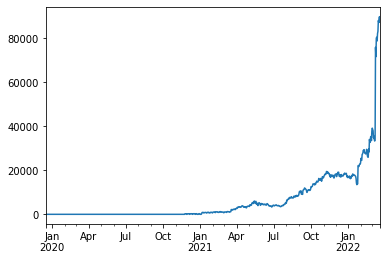

In [54]:
final_df.sum(axis = 1).plot()

<AxesSubplot:>

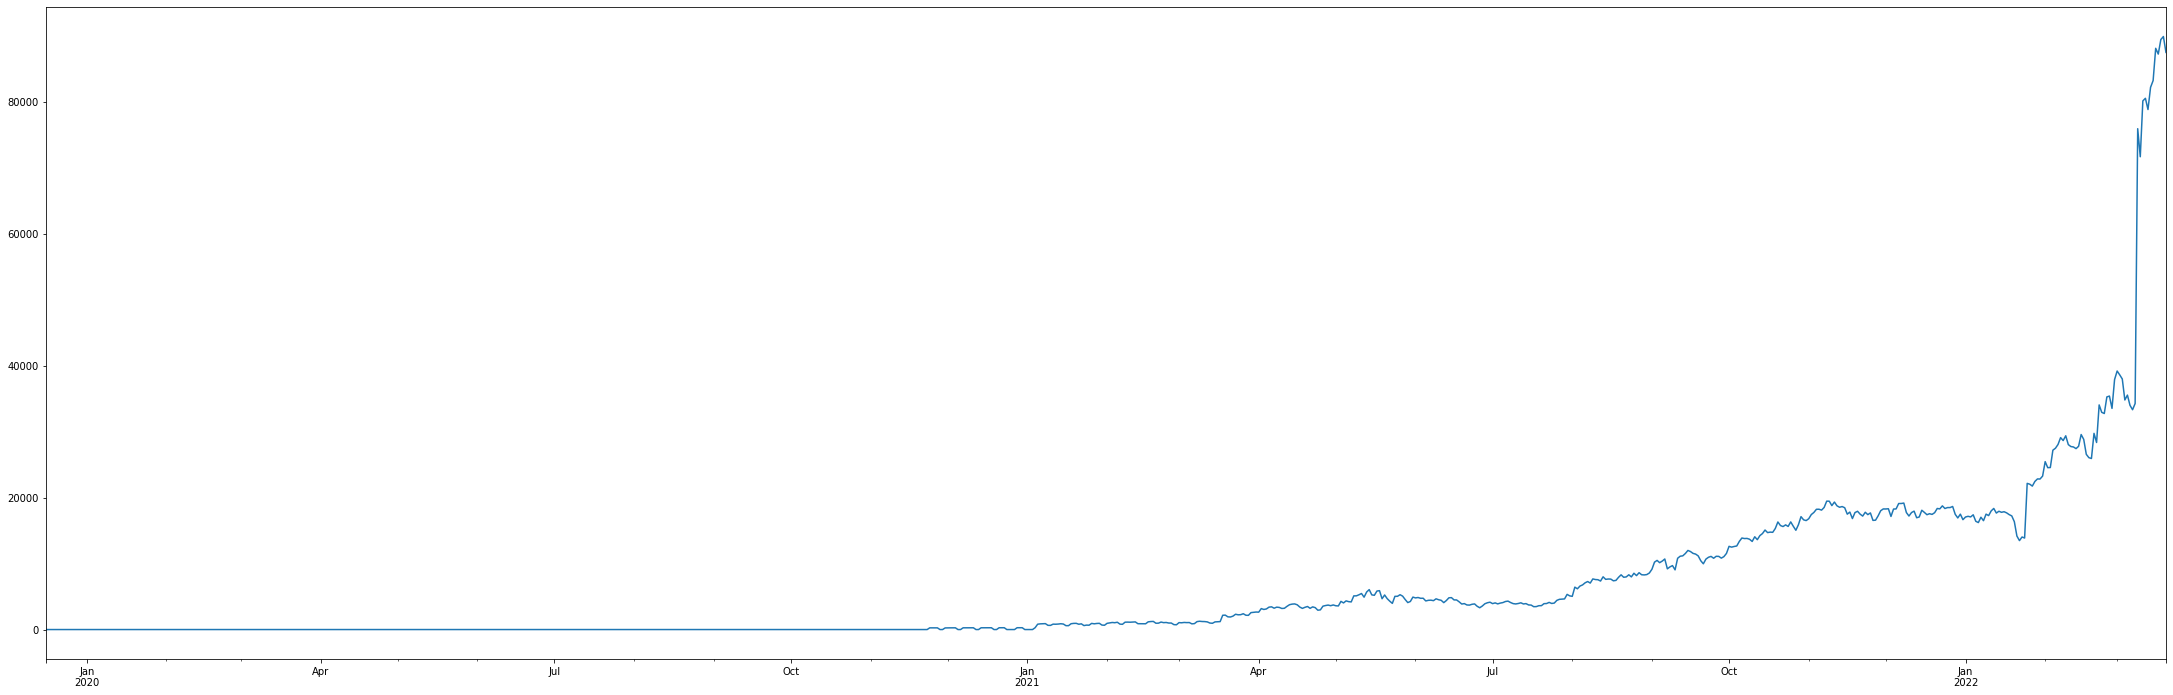

In [55]:
final_df.sum(axis = 1)[:-1].plot(figsize=(38,12))

<AxesSubplot:>

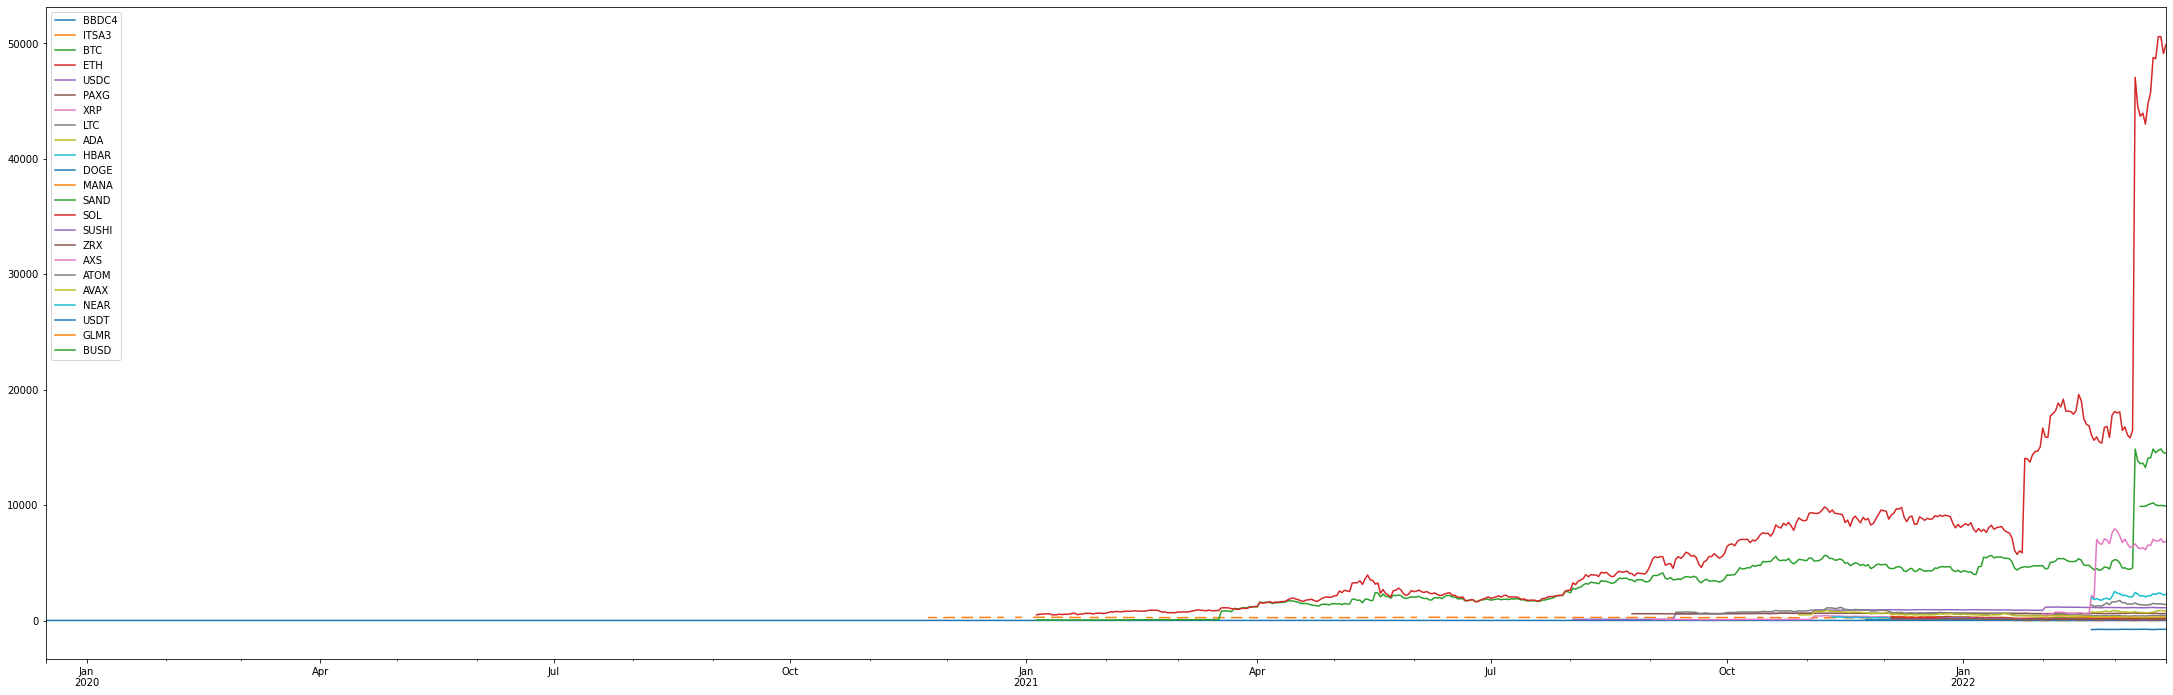

In [56]:
final_df.plot(figsize=(38,12))

<AxesSubplot:>

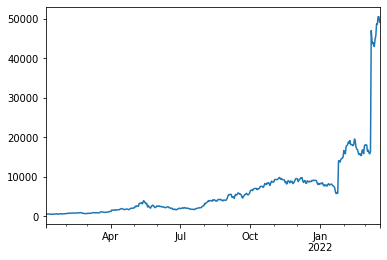

In [73]:
ativo = 'ETH'
final_df[ativo][~final_df[ativo].isna()].plot()

Patrimônio de BTC hoje: R$9903.72


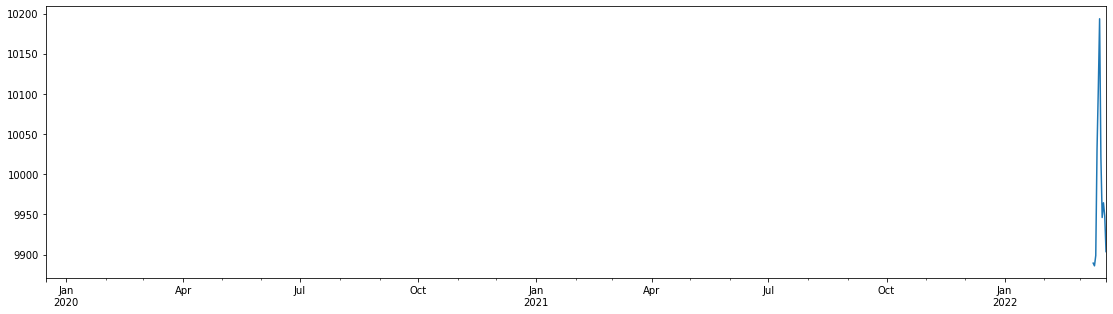

In [58]:
qtt['Patrimônio'].plot(figsize=(19,5))
hoje = qtt['Patrimônio'][-1]

print(f'Patrimônio de BTC hoje: R${round(hoje, 2)}')

<AxesSubplot:>

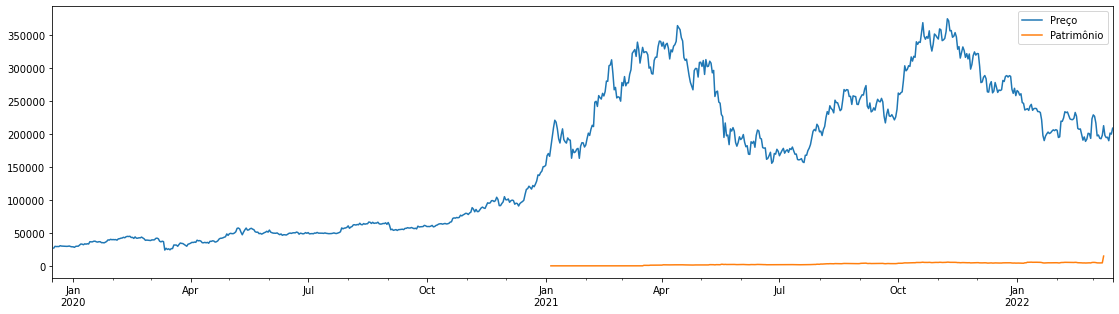

In [85]:
btc_qtt[['Preço', 'Patrimônio']].plot(figsize=(19,5))